In [29]:
import pandas as pd
import numpy as np
import csv
import scipy.sparse
import matplotlib.pyplot as plt

movie_file = "ml-1m/movies.dat"
m_names = ["bad_index", "Title", "Genre"]
movies = pd.read_csv(movie_file, nrows=1_000_000, header=None, names=m_names, sep="::", engine='python')
movie_to_index = dict((m,i) for i,m in zip(movies.index, movies["bad_index"]))
movie_to_genre = dict((i,g) for i,g in zip(movies.index, movies["Genre"]))

input_file = "ml-1m/ratings.dat"
names = ["Movie", "Rating", "Not_Needed"]
data = pd.read_csv(input_file, nrows=1_000_000, header=None, names=names, sep="::", engine='python')
data.index.name="User"


In [27]:
ratings = np.zeros(shape=(6040, 3883))
for d in data.itertuples():
    movie = movie_to_index[getattr(d, 'Movie')]
    user = int(d[0])
    rating = getattr(d, 'Rating')
    ratings[user-1][movie] = rating

np.save("1M_ratings_np", ratings)

In [30]:
genre_to_int = {
    'Action' : 0,
    'Adventure' : 1,
    'Animation' : 2,
    'Children\'s' : 3,
    'Comedy' : 4,
    'Crime' : 5,
    'Documentary' : 6,
    'Drama' : 7,
    'Fantasy' : 8,
    'Film-Noir' : 9, 
    'Horror' : 10,
    'Musical' : 11,
    'Mystery' : 12,
    'Romance' : 13,
    'Sci-Fi' : 14,
    'Thriller' : 15,
    'War' : 16,
    'Western' : 17, 
}

def get_genres_for_movie(movie, curr):
    inds = [genre_to_int[genre] for genre in movie_to_genre[movie].split('|')]
    for i in inds:
        curr[i] += 1
    return curr

def get_top_k_genres_for_user(mat, user, k):
    movies = mat[user]
    genre_prefs = np.zeros(len(genre_to_int))
    average_rating = movies[np.nonzero(movies)].mean()
    for i,movie in enumerate(movies):
        if movie > average_rating:
            genre_prefs = get_genres_for_movie(i, genre_prefs)
    return np.flip(np.argsort(genre_prefs))[:k]

0
1000
2000
3000
4000
5000
[7, 7, 1, 0, 7, 13, 0, 7, 7, 4, 4, 7, 1, 7, 7, 4, 14, 7, 0, 0, 2, 4, 14, 4, 0, 4, 7, 7, 0, 7, 4, 7, 7, 4, 7, 7, 13, 4, 4, 1, 14, 0, 4, 4, 4, 10, 7, 7, 0, 7, 4, 0, 7, 4, 7, 7, 7, 7, 7, 1, 0, 7, 7, 0, 0, 7, 7, 4, 7, 4, 0, 7, 0, 7, 3, 7, 4, 4, 12, 7, 7, 7, 8, 0, 15, 1, 0, 7, 7, 4, 4, 4, 0, 10, 7, 7, 7, 7, 4, 0, 0, 4, 0, 4, 0, 13, 7, 4, 4, 5, 7, 2, 0, 3, 0, 8, 0, 0, 4, 7, 14, 0, 7, 7, 0, 13, 0, 4, 0, 0, 7, 4, 7, 0, 4, 7, 0, 7, 0, 7, 7, 7, 0, 7, 4, 7, 0, 0, 7, 7, 4, 4, 4, 4, 4, 4, 4, 7, 4, 7, 7, 0, 0, 13, 14, 7, 7, 4, 4, 7, 6, 9, 7, 0, 7, 4, 1, 11, 14, 7, 7, 4, 7, 3, 0, 0, 7, 7, 7, 7, 4, 7, 7, 4, 7, 15, 7, 4, 7, 4, 4, 4, 7, 7, 4, 14, 4, 7, 4, 0, 15, 4, 4, 4, 14, 4, 4, 4, 4, 4, 12, 0, 4, 7, 7, 4, 15, 15, 7, 7, 4, 4, 11, 7, 7, 0, 4, 7, 7, 0, 14, 4, 4, 4, 7, 4, 7, 0, 4, 0, 0, 0, 7, 10, 7, 0, 7, 7, 7, 0, 7, 14, 4, 4, 11, 4, 7, 7, 4, 7, 4, 4, 0, 7, 7, 4, 0, 10, 16, 4, 7, 15, 0, 4, 7, 7, 7, 0, 15, 7, 7, 7, 7, 4, 0, 10, 4, 4, 7, 7, 4, 4, 7, 9, 10, 4, 7, 7, 7, 4, 0, 7, 4,

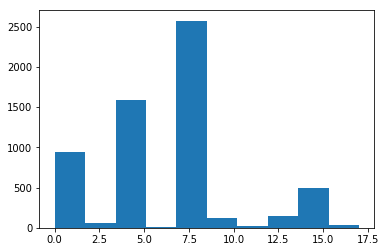

In [34]:
g = []
for i in range(6000):
    if i % 1000 == 0:
        print(i)
    g.append(get_top_k_genres_for_user(ratings, i, 1)[0])



41 1564


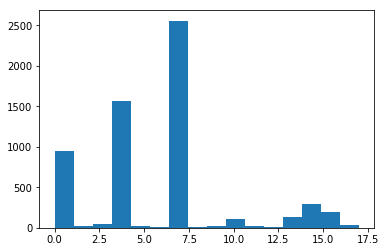

In [38]:
plt.hist(g, bins=16)
x = [i for i in g if i == 3]
y = [i for i in g if i == 4]

print(len(x), len(y))
plt.show()

In [11]:
import numpy as np
# translated from lmafit_mc_adp.m by Mark Crovella December 2014
# omitting many options and just implementing the core functionality
# for documentation on lmafit see http://lmafit.blogs.rice.edu/
#
# Note: this is very useful:
# http://wiki.scipy.org/NumPy_for_Matlab_Users
#
def lmafit_mc_adp(m,n,k,Known,data,opts):
    """
 Output:
           X --- m x k matrix
           Y --- k x n matrix
         Out --- output information
 Input:
        m, n --- matrix sizes
           k --- rank estimate
       Known is a 2xL ndarray holding indices of known elements 
        data --- values of known elements in a 1D row vector
        opts --- option structure (not used)
    """
    L = len(data)
    tol = 1.25e-4
    maxit = 500
    iprint = 0
    reschg_tol = 0.5*tol
    datanrm = np.max([1.0,np.linalg.norm(data)])
    objv = np.zeros(maxit)
    RR = np.ones(maxit)
    if iprint == 1:
        print('Iteration: ')
    if iprint == 2:
        print('\nLMafit_mc: \n')

    # initialize: make sure the correctness of the index set and data
    data[data==0]=np.spacing(1)
    data_tran = False
    Z = np.zeros((m,n))
    Z[Known] = data

    if m>n:
        tmp = m
        m = n
        n = tmp
        Z = Z.T
        Known = np.nonzero(Z)
        data = Z[Known]
        data_tran = True

    # assuming no inital solutions provided
    X = np.zeros((m,k))
    Y = np.eye(k,n)
    Res = data
    res = datanrm

    # parameters for alf
    alf = 0
    increment = 1
    itr_rank = 0
    minitr_reduce_rank = 5
    maxitr_reduce_rank = 50

    for iter in range(maxit):
        itr_rank += 1
        Xo = X
        Yo = Y
        Res0 = Res
        res0 = res
        alf0x = alf
        # iterative step
        # Zfull option only
        Zo = Z
        X = Z.dot(Y.T)
        X, R = np.linalg.qr(X)
        Y = X.T.dot(Z)
        Z = X.dot(Y)
        Res = data - Z[Known]
        #
        res = np.linalg.norm(Res)
        relres = res/datanrm
        ratio = res/res0
        reschg = np.abs(1-res/res0)
        RR[iter] = ratio
        # omitting rank estimation
        # adjust alf
        if ratio>=1.0:
            increment = np.max([0.1*alf, 0.1*increment])
            X = Xo
            Y = Yo
            Res = Res0
            res = res0
            relres = res/datanrm
            alf = 0
            Z = Zo
        elif ratio>0.7:
            increment = max(increment, 0.25*alf)
            alf = alf+increment;
    
        if iprint==1:
            print('{}'.format(iter))
        if iprint==2:
            print('it: {} rk: (none), rel. {} r. {} chg: {} alf: {} inc: {}\n'.format(iter, k, relres,ratio,reschg,alf0x,increment))

        objv[iter] = relres

        # check stopping
        if ((reschg < reschg_tol) and ((itr_rank > minitr_reduce_rank) or (relres < tol))):
            break
    
        Z[Known] = data + alf*Res

    if iprint == 1:
        print('\n')

    if data_tran:
        tX = X
        X = Y.T
        Y = tX.T

    obj = objv[:iter]

    return X, Y, [obj, RR, iter, relres, reschg]

In [12]:

mvs = [movie_to_index[i] for i in data["Movie"].tolist()]
usr = [u-1 for u in data.index.tolist()]
Known = np.stack([usr,mvs], axis=0)

rats = data["Rating"]

kn = Known[0],Known[1]

a,b, c = lmafit_mc_adp(6040, 3883, 10, kn, rats, None)
recon = a@b
print(np.max(recon))
# np.save("lmafit_out", recon)

9.354993310720781


In [21]:
ratings = [1, 2, 3, 4, 1, 2, 3]
users =   [0, 0, 0, 0, 1, 1, 1]
movies =  [0, 1, 2, 3, 0, 2, 2]

x, y, _ = lmafit_mc_adp(2, 4, 5, (users, movies), ratings, None)
completed = x.dot(y)
print(completed.astype(np.int))

[[0 2 3 4]
 [1 0 3 0]]
